# HBV hydrological model run locally outside container forced with ERA5 forcing data
In this notebook we will demonstrate how to run a local version of HBV. A local version does not rely on a container, but instead runs directly on the machine that also runs the experiment. This has a downside: 

- the execution of the model code becomes dependent on the software available at the experiment machine. This breaks a fundamental eWaterCycle design rule.

But also a big upside:

- for a small model like HBV starting and stopping a container is a lot of computational overhead. Using a local model allows many more model runs in the same time.

This notebook is purely to show the one difference between running HBV local and running HBV normally in a container. This assumes you have already seen [the standard notebook explaining how to run HBV on eWaterCycle.](example_model_run_HBV_camels_catchment_camels_foring.ipynb)

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
from tqdm import tqdm

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
# eWaterCycle Data assimilation package
from ewatercycle_DA import DA

In [4]:
# region selected
caravan_id = "camelsgb_73010"

In [5]:
# time periods for experiment
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"

# pre-generated forcing from caravan
Here we re-load the forcing we generated in [this](example_model_run_HBV_camels_catchment_camels_foring.ipynb) notebook. 

In [6]:
# location of caravan forcing
# This was generated 
forcing_path_caravan = Path.home() / "forcing" / caravan_id / "caravan"

In [7]:
# load the caravan forcing object
caravan_forcing_object = ewatercycle.forcing.sources['CaravanForcing'].load(directory=forcing_path_caravan)
print(caravan_forcing_object)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/forcing/camelsgb_73010/caravan'),
    shape=PosixPath('/home/rhut/forcing/camelsgb_73010/caravan/camelsgb_73010.shp'),
    filenames={
        'tasmin': 'camelsgb_73010_1997-08-01_2000-08-31_tasmin.nc',
        'tasmax': 'camelsgb_73010_1997-08-01_2000-08-31_tasmax.nc',
        'evspsblpot': 'camelsgb_73010_1997-08-01_2000-08-31_evspsblpot.nc',
        'pr': 'camelsgb_73010_1997-08-01_2000-08-31_pr.nc',
        'Q': 'camelsgb_73010_1997-08-01_2000-08-31_Q.nc',
        'tas': 'camelsgb_73010_1997-08-01_2000-08-31_tas.nc'
    }
)

## create an ensemble of models

In [8]:
n_particles = 100

In [11]:
p_min_initial = np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,   0])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,   10])


parameters = np.zeros([9, n_particles])

# Here I use np.linspace to make a linear interpolation between the minimum and maximum parameters. 
# Realize that this means that the first model will get all low parameters and the last model will get all high parameters. 
# This can be done much smarter.
for param in range(8):
    parameters[param,:] = np.linspace(p_min_initial[param],p_max_initial[param],n_particles)

In [12]:
#print parameter names and values for first ensemble member
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
print(list(zip(param_names, np.round(parameters[:,0], decimals=3))))

[
    ('Imax', 0.0),
    ('Ce', 0.2),
    ('Sumax', 40.0),
    ('Beta', 0.5),
    ('Pmax', 0.001),
    ('Tlag', 1.0),
    ('Kf', 0.01),
    ('Ks', 0.0),
    ('FM', 0.0)
]

In [13]:
# set inital state values
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

In [14]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [15]:
# values wihch you 
setup_kwargs_lst = []
for index in range(n_particles):
    setup_kwargs_lst.append({'parameters': parameters[:,index],
                             })

In [16]:
# this initializes the models for all ensemble members. - ignore warnings for now 
ensemble.initialize(model_name=["HBVLocal"]*n_particles,
                    forcing=[caravan_forcing_object]*n_particles,
                    setup_kwargs=setup_kwargs_lst) 

In [17]:
ref_model = ensemble.ensemble_list[0].model

In [18]:

n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)

time = []
lst_Q = [] 
for i in tqdm(range(n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    ensemble.update()
    lst_Q.append(ensemble.get_value("Q").flatten())



100%|██████████| 1126/1126 [00:30<00:00, 36.71it/s]


In [19]:
ensemble.finalize()

In [20]:
Q_m_arr = np.array(lst_Q).T
df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

<Axes: >

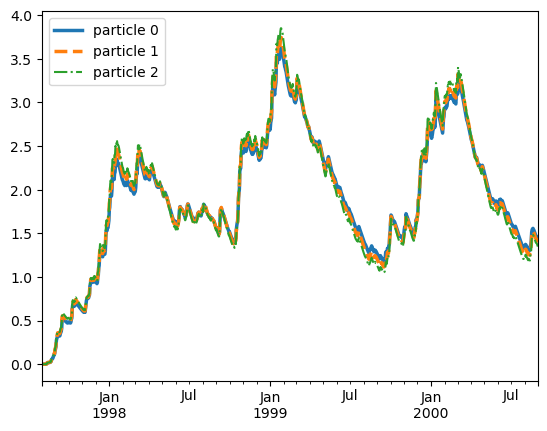

In [21]:
ax = df_ensemble[["particle 0"]].plot(lw=2.5)
df_ensemble[["particle 1"]].plot(ax=ax,ls="--",lw=2.5)
df_ensemble[["particle 2"]].plot(ax=ax,ls="-.",lw=1.5)

<Axes: >

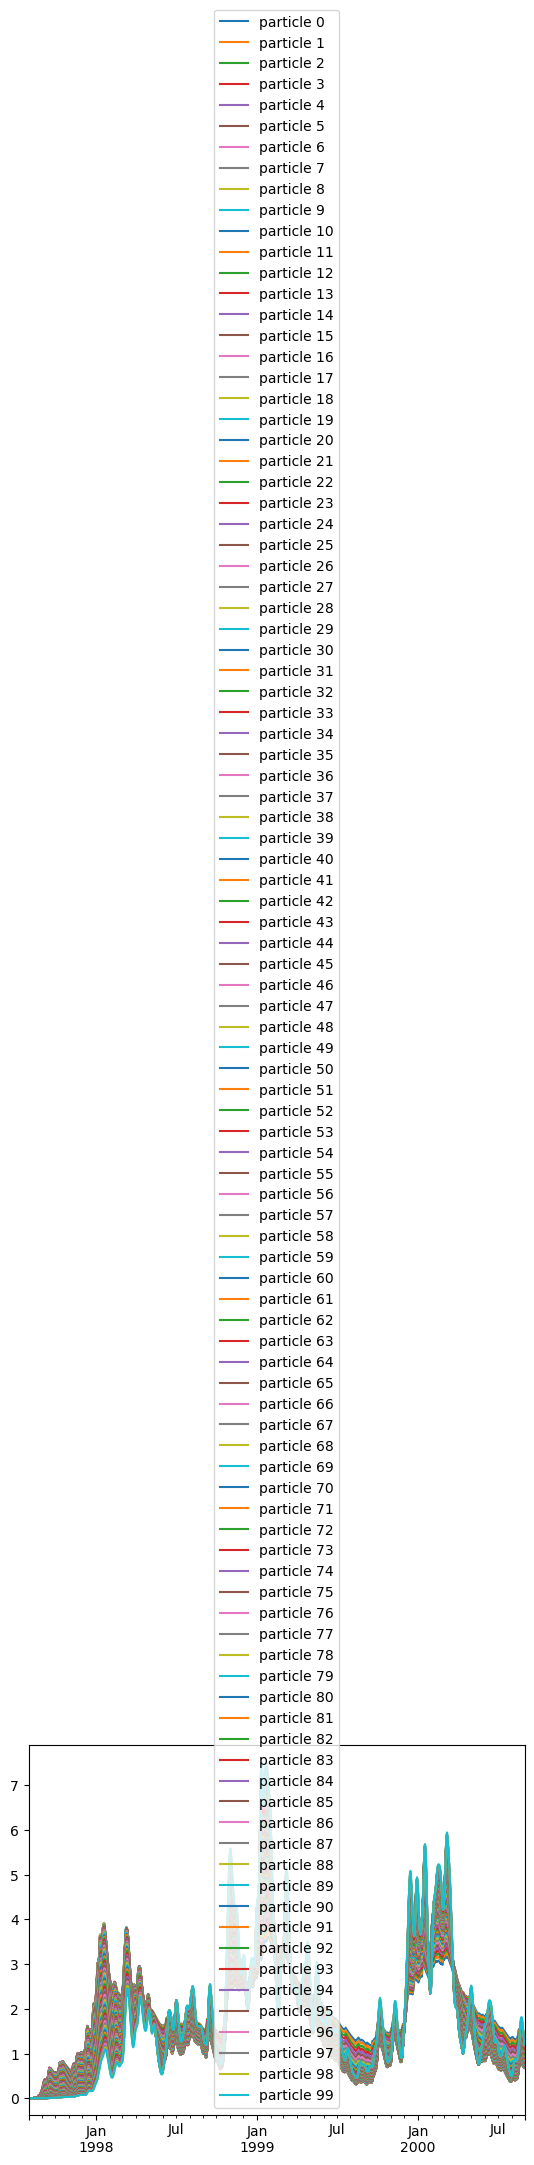

In [22]:
df_ensemble.plot()

## Process results
Finally, we use standard python libraries to visualize the results. We put the model output into a pandas Series to make plotting easier.

In [ ]:
#make a pandas series
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

In [ ]:
#load the observations from the caravan object
caravan_discharge_observation = xr.open_mfdataset([caravan_forcing_object['Q']])


In [ ]:
#make a plot of both the observations and modelled discharge
model_output.plot()
caravan_discharge_observation["Q"].plot(label="Observed discharge")
plt.legend()
plt.ylabel("Discharge (mm/d)")

In [ ]:
#we want to also be able to use the output of this model run in different analyses. Therefore we save it as a NetCDF file
xr_model_output = model_output.to_xarray()

xr_model_output.attrs['units'] = 'mm/d'

# Save the xarray Dataset to a NetCDF file
xr_model_output.to_netcdf('~/river_discharge_data.nc')